# Langchain : Chat bot

## Install required library

In [8]:
!pip install langchain-core langgraph==0.5.4
!pip install -U langchain-openai

  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.5.0
    Uninstalling langgraph-0.5.0:
      Successfully uninstalled langgraph-0.5.0


## LangSmith

Inspect what going on inside your chain or agent

In [9]:
import os
import sys
sys.path.append('..')
from secret.secret_key import openapi_key, serapapi_key, second_openai_key, langsmith_key
os.environ['OPENAI_API_KEY'] = second_openai_key
os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_API_KEY'] = langsmith_key

## Get start

In [3]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-4o-mini", model_provider="openai")

In [4]:
#Manually call ChatModel
from langchain_core.messages import HumanMessage

model.invoke([HumanMessage(content="Hi! I'm Zezar")])

AIMessage(content='Hi, Zezar! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 12, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3iIEleTIzuJniZzjNVqt9h2YzjnE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd247b52-175c-4d0b-9442-c34dc6bde7a3-0', usage_metadata={'input_tokens': 12, 'output_tokens': 12, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Normally model on its own not have any concept of state. So, by asking question relate to previous conversation. Model can't answer correctly.

In [5]:
model.invoke([HumanMessage(content="What's my name?")])

AIMessage(content="I'm sorry, but I don't have access to personal information unless you share it with me. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3iIGTgjW6HWbx8AE7wKfLdzv67yF', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d2538966-a8f8-465f-834e-219e5222183c-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

We need to pass the entire <b>conversation history</b> in the model

In [6]:
from langchain_core.messages import AIMessage

model.invoke(
    [
        HumanMessage(content="Hi! I'm Zezar"),
        AIMessage(content="Hello Zezar! How can I assist you today?"),
        HumanMessage(content="What's my name?"),
    ]
)

AIMessage(content='Your name is Zezar! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 35, 'total_tokens': 48, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C3iIHUg6jemr7Ko0DtIDE5s3NbCvE', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--49a3701f-9a63-47f4-bf71-f5dfc1cce6b2-0', usage_metadata={'input_tokens': 35, 'output_tokens': 13, 'total_tokens': 48, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## LangGraph

implements a built-in persistence layer, can support multiple conversation turns. Wrapping our chat model in LangGraph allows us to automatically persist the message history. LangGraph comes with simple in-memory checkpointer (can use different persistence backends - SQLite or Postgres)

In [10]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# Define the (single) node in the graph
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

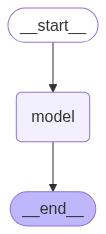

In [11]:
from IPython.display import Image, display
# View
display(Image(app.get_graph().draw_mermaid_png()))

we now need to create a <b>config</b> that we pass into the runnable every time. This config contains information that is not part of the input directly, but is still useful. In this case, we want to incluse a <b>thread_id</b>

In [8]:
config = {"configurable": {"thread_id": "abc123"}}

This enable app to supprt multiple conversation threads with a single application (common requirement for application with multiple users.)

In [ ]:
query = "Hi! I'm Zezar."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config) # include config to gether history
output["messages"][-1].pretty_print()  # output contains all messages in state

================================== Ai Message ==================================

Hi Zezar! Great to meet you! How can I help you today?


In [11]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Zezar! How can I help you today?


If we change the config to reference a different <b>thread_id</b>. the conversation will start fresh

In [12]:
config = {"configurable": {"thread_id": "abc234"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't have access to personal data about users unless it's shared with me during our conversation. So, I don't know your name. How can I assist you today?


We can always go back to original conversations (because persisting in a database)

In [13]:
config = {"configurable": {"thread_id": "abc123"}}

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Zezar. If there's anything specific you'd like to chat about or ask, feel free!


For async support, update the <b>call_model</b> node to be async function and use <b>.ainvoke</b> when invoking the applications

In [ ]:
config = {"configurable": {"thread_id": "abc123"}}

# Async function for node:
async def call_model(state: MessagesState):
    response = await model.ainvoke(state["messages"])
    return {"messages": response}


# Define graph as before: (because define new Graph even though use same config. Program can't get chat history )
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
app = workflow.compile(checkpointer=MemorySaver())

# Async invocation:
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I'm sorry, but I don't know your name. If you'd like, you can share it with me!


## Prompt template

turn raw user information into a format that the LLM can work with

In [16]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You talk like a pirate. Answer all questions to the best of your ability.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [17]:
workflow = StateGraph(state_schema=MessagesState)


def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state) # add template
    response = model.invoke(prompt)
    return {"messages": response}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [18]:
config = {"configurable": {"thread_id": "abc345"}}
query = "Hi! I'm Jim."

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ahoy, Jim! Welcome aboard me ship! What be ye seekin' on this fine day? Arrr!


In [19]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Ye be called Jim, if I be readin’ me notes right! What else can I do fer ye, matey? Arrr!


- add <b>language</b> input to prompt.

In [23]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. Answer all questions to the best of your ability in {language}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [24]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

# update application's state
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str


workflow = StateGraph(state_schema=State)


def call_model(state: State):
    prompt = prompt_template.invoke(state)
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [25]:
config = {"configurable": {"thread_id": "abc456"}}
query = "Hi! I'm Bob."
language = "Spanish"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Hola, Bob! ¿Cómo puedo ayudarte hoy?


The entire state is persisted, so we can omit parameters like <b>language</b> if no changes are desired

In [26]:
query = "What is my name?"

input_messages = [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Tu nombre es Bob.


## Managing Conversation History

Important concept of chatbot is how to manage conversation history. If let unmanaged, the list of messages will grow unbounded and potentially overflow the context window of LLM. So, it important to add limit size of messages you are passing

We can do this by adding a step in front of the prompt that modifies the <b>messages</b> key and then wrap that new chain in the Message history class. (before prompt template but after load previous messages from Message history)

In [76]:
from langchain_core.messages import SystemMessage, trim_messages

# managing list of messages
trimmer = trim_messages( # reduce how many message send to model
    max_tokens=91, # How many tokens we want to keep
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

need to run the trimmer before pass the <b>messages</b> input to our prompt

In [77]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"]) # add trimmer here
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt) # before prompt here
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [78]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)] # load previous messages from Message history
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't know your name. If you'd like to share it, feel free!


In [71]:
input_messages

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}, id='4103a7e3-d2ac-4a81-bec7-8b02b66097b3'),
 HumanMessage(content="hi! I'm bob", additional_kwargs={}, response_metadata={}, id='f08fdf43-1112-4444-a2cb-a82e1503f2bf'),
 AIMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='5e133866-7f81-4bd6-a1ae-ce67dbbcc46f'),
 HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}, id='48556773-11af-47a2-b563-b072d124894f'),
 AIMessage(content='nice', additional_kwargs={}, response_metadata={}, id='151bea29-403a-417d-b8b7-6dfb94c47e61'),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}, id='e796614a-3a34-4060-8375-c6dfe9754271'),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}, id='eb67b07c-3e5d-4645-ac49-f0c593acad5c'),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}, id='0dfb4288-3613-497d-9714-eb7efcf998c4'),
 AIMessage(co

if ask about information that is within the last few messages, it remembers

In [79]:
config = {"configurable": {"thread_id": "abc678"}}
query = "What math problem did I ask?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

You asked what 2 + 2 equals.


## Streaming

LLM can take a while to respond and to improve UX the one thing that most applications do is stream back each token as it is generated. This allow user to see progress.

In [82]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a history of America."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|Hi| Todd|!| Here|’s| a| brief| overview| of| the| history| of| America|:

|**|Pre|-Col|umb|ian| Era|:**| Before| European| exploration|,| the| Americas| were| inhabited| by| various| Indigenous| peoples| with| diverse| cultures| and| societies|.| Not|able| civilizations| included| the| Maya|,| Az|tec|,| and| In|ca| in| Central| and| South| America|,| as| well| as| various| tribes| across| North| America|.

|**|European| Exploration| and| Colon|ization| (|149|2| -| |160|0|s|):|**| Christopher| Columbus| arrived| in| the| Caribbean| in| |149|2|,| marking| the| beginning| of| European| colon|ization|.| Following| Columbus|,| other| explorers| like| Hern|án| Cort|és| and| Francisco| P|izar|ro| conquered| large| em|pires| in| the| Americas|.| The| Spanish|,| French|,| and| English| established| colonies|,| leading| to| significant| changes| in| the| Indigenous| way| of| life|.

|**|Colon|ial| America| (|160|7| -| |177|6|):|**| The| English| established| their| first| permanent| colony| at|